In [184]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data.sampler import WeightedRandomSampler


In [185]:
df = pd.read_csv("./data/extracted_info.csv")

In [186]:
df.head()

,id,report,r_cc,r_mlo,l_cc,l_mlo,left_birads,right_birads,composition,left_microcal,right_microcal,left_mass,right_mass
0,10375048,Heterogeneously dense breasts (BIRADS: 2) No s...,./jpegs/10375048_r_cc.jpeg,./jpegs/10375048_r_mlo.jpeg,./jpegs/10375048_l_cc.jpeg,./jpegs/10375048_l_mlo.jpeg,2.0,2.0,Z,0.0,0.0,0.0,0.0
1,11079112,Heterogeneously dense breasts (breast composit...,./jpegs/11079112_r_cc.jpeg,./jpegs/11079112_r_mlo.jpeg,./jpegs/11079112_l_cc.jpeg,./jpegs/11079112_l_mlo.jpeg,2.0,2.0,C,0.0,0.0,0.0,0.0
2,11176724,Heterogeneously dense breasts are noted (breas...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11374138,Scattered areas of glandular density are noted...,./jpegs/11374138_r_cc.jpeg,./jpegs/11374138_r_mlo.jpeg,./jpegs/11374138_l_cc.jpeg,./jpegs/11374138_l_mlo.jpeg,0.0,0.0,B,1.0,1.0,-1.0,-1.0
4,11381956,Scattered areas of glandular density are noted...,./jpegs/11381956_r_cc.jpeg,./jpegs/11381956_r_mlo.jpeg,./jpegs/11381956_l_cc.jpeg,./jpegs/11381956_l_mlo.jpeg,-1.0,0.0,B,-1.0,-1.0,-1.0,-1.0


In [187]:
def fill_nans_birads(row):
    if pd.isna(row.right_birads) and pd.isna(row.left_birads):
        return row
    elif pd.isna(row.right_birads):
        row.right_birads = -1
        return row
    elif pd.isna(row.left_birads):
        row.left_birads = -1
        return row
    else:
        return row

In [188]:
def fill_nans_calcifications(row):
    if pd.notna(row.right_microcal) and pd.notna(row.left_microcal):
        if row.right_microcal == -1:
            row.right_microcal = 0
        if row.left_microcal == -1:
            row.left_microcal = 0
    return row

In [189]:
def fill_nans_masses(row):
    if pd.notna(row.right_mass) and pd.notna(row.left_mass):
        if row.right_mass == -1:
            row.right_mass = 0
        if row.left_mass == -1:
            row.left_mass = 0
    return row

In [190]:
def any_mass(row):
    if pd.notna(row.right_mass) and pd.notna(row.left_mass):
        if row.right_mass == 1 or row.left_mass == 1:
            return 1
        else:
            return 0
    else:
        return np.nan

In [191]:
def any_calcification(row):
    if pd.notna(row.right_microcal) and pd.notna(row.left_microcal):
        if row.right_microcal == 1 or row.left_microcal == 1:
            return 1
        else:
            return 0
    else:
        return np.nan

In [192]:
def max_birads(row):
    if pd.isna(row.left_birads) and pd.isna(row.right_birads):
        return np.nan
    elif pd.isna(row.left_birads):
        return row.right_birads
    elif pd.isna(row.right_birads):
        return row.left_birads
    else:
        return max(row.left_birads, row.right_birads)

In [193]:
df.composition = df.composition.str.upper().astype("category")
df.left_mass = df.left_mass.astype("Int64")
df.right_mass = df.right_mass.astype("Int64")
df.left_microcal = df.left_microcal.astype("Int64")
df.right_microcal = df.right_microcal.astype("Int64")
df.left_birads = df.left_birads.astype("Int64")
df.right_birads = df.right_birads.astype("Int64")

In [194]:
df = df.apply(fill_nans_birads, axis=1)
df = df.apply(fill_nans_calcifications, axis=1)
df = df.apply(fill_nans_masses, axis=1)

In [195]:
df["max_birads"] = df.apply(max_birads, axis=1).astype("category")
df["any_mass"] = df.apply(any_mass, axis=1).astype("category")
df["any_calcification"] = df.apply(any_calcification, axis=1).astype("category")

In [196]:
df = df.dropna(how="any", subset=["max_birads", "any_calcification", "composition", "any_mass"])

In [197]:
len(df)

13953

In [198]:
# plot a heatmap of max_birads vs composition (both are categorical)
def plot_heatmap(df, x_col, y_col, title):
    df_grouped = df.groupby([x_col, y_col]).size().reset_index(name='counts')
    df_pivot = df_grouped.pivot(index=x_col, columns=y_col, values='counts').fillna(0)
    plt.figure(figsize=(6, 6))
    sns.heatmap(df_pivot, annot=True, fmt=",", cmap="YlGnBu")
    plt.title(title)
    plt.xlabel(y_col)
    plt.ylabel(x_col)
    plt.show()


/var/folders/_d/0vwb7s9d6b51rjy794vvr7y80000gn/T/ipykernel_19739/77215205.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby([x_col, y_col]).size().reset_index(name='counts')


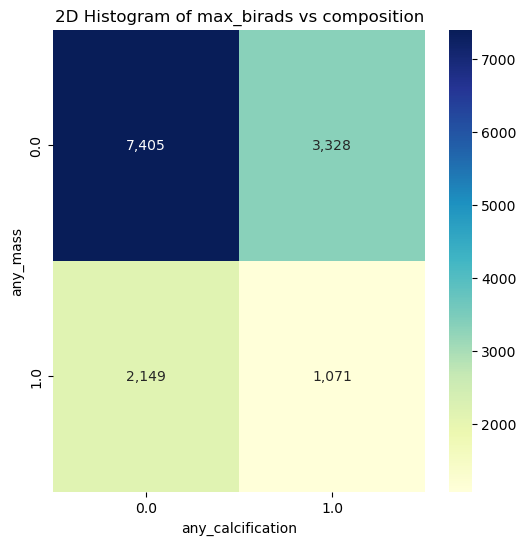

In [199]:

plot_heatmap(df, "any_mass", "any_calcification", "2D Histogram of max_birads vs composition");

In [200]:
def make_nd_pmf(df, cols: list[str]):
    """
    Make an n-dimensional PMF from the specified columns in the dataframe.
    Returns a dict mapping each combination of values to its probability.
    """
    # count occurrences of each combination
    counts = df.groupby(cols).size()
    # normalize to get probabilities
    pmf = counts / counts.sum()
    # if only one column, return scalar-key dict
    if len(cols) == 1:
        return pmf.to_dict()
    # else return tuple-key dict
    return {tuple(idx): prob for idx, prob in pmf.items()}

In [201]:
from typing import Literal


def pmf_to_weight(
    pmf: dict[tuple, float],
    peakedness: float = 0.00,
    eps: float = 1e-6,
    ignore_zero: bool = True,
    normalize_to: Literal["median", "mean", "sum", "min", "max"] = "median",
) -> dict[tuple, float]:
    """
    Convert a PMF to a weight dictionary.
    The weights are the inverse of the probabilities.
    The weights are normalized to sum to 1.
    The weights are smoothed by adding a small constant to each weight.
    if ignore_zero is True, the weights for zero probabilities are set to 0.
    """
    norm_fn = {
        "median": np.median,
        "mean": np.mean,
        "sum": np.sum,
        "min": np.min,
        "max": np.max,
    }.get(normalize_to, np.median)
    total = sum(pmf.values())
    weights = {k: (total / (v + eps)) for k, v in pmf.items()}

    if ignore_zero:
        weights = {k: w for k, w in weights.items() if pmf[k] > 0}

    weights = {k: w / sum(weights.values()) for k, w in weights.items()}
    weights = {k: w + peakedness for k, w in weights.items()}
    weights = {k: w / norm_fn(list(weights.values())) for k, w in weights.items()}
    return weights

In [202]:
def plot_2d_pmf(pmf: dict[tuple, float], title: str, captions: list[str] = None):
    """
    Plot a 2D PMF as a heatmap.
    """
    # convert to DataFrame
    df = pd.DataFrame.from_dict(pmf, orient='index', columns=['prob'])
    df.reset_index(inplace=True)
    df[['x', 'y']] = pd.DataFrame(df['index'].tolist(), index=df.index)
    df.drop(columns=['index'], inplace=True)

    # pivot for heatmap
    df_pivot = df.pivot(index='x', columns='y', values='prob')
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(title)
    if captions is None:
        plt.xlabel('y')
        plt.ylabel('x')
    else:
        plt.xlabel(captions[1])
        plt.ylabel(captions[0])
    plt.show()


In [203]:
pmf = make_nd_pmf(df, ["any_mass", "any_calcification"])

/var/folders/_d/0vwb7s9d6b51rjy794vvr7y80000gn/T/ipykernel_19739/2993855522.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(cols).size()


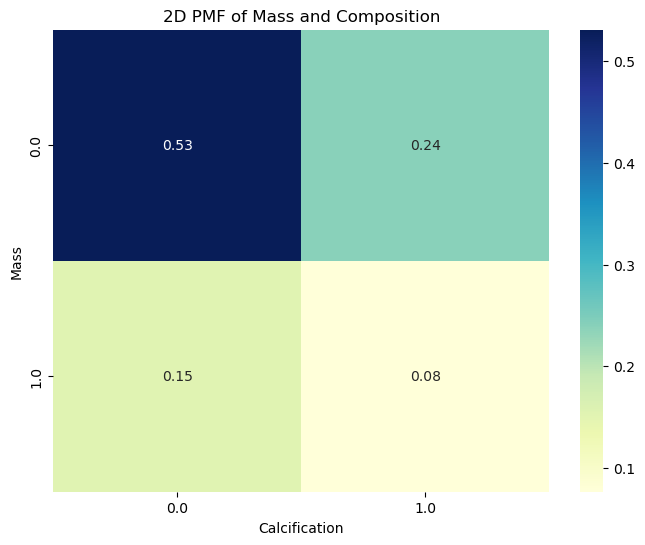

In [204]:
plot_2d_pmf(pmf, "2D PMF of Mass and Composition", captions=["Mass", "Calcification"])

In [205]:
weights = pmf_to_weight(pmf, peakedness=0.00)

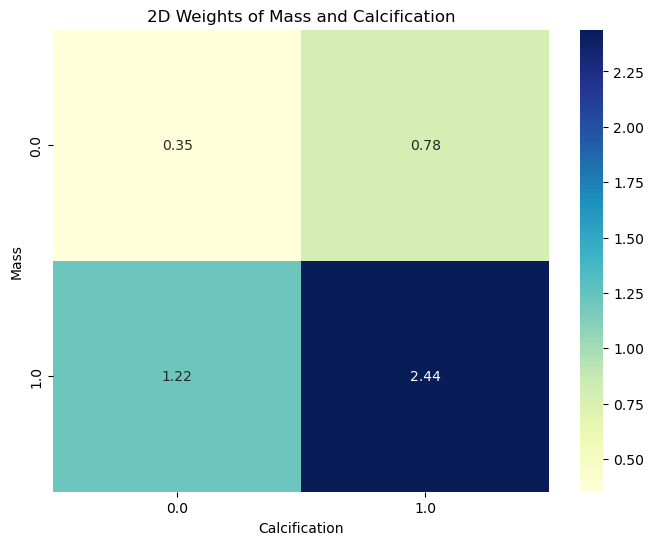

In [206]:
plot_2d_pmf(weights, "2D Weights of Mass and Calcification", captions=["Mass", "Calcification"])

In [207]:
overall_pmf = make_nd_pmf(df, (ordering:=["any_mass", "any_calcification", "max_birads", "composition"]))

/var/folders/_d/0vwb7s9d6b51rjy794vvr7y80000gn/T/ipykernel_19739/2993855522.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(cols).size()


In [208]:
overall_weights = pmf_to_weight(overall_pmf, normalize_to="median")
overall_weights

{(0.0, 0.0, -1.0, 'A'): 0.9000697163623799,
 (0.0, 0.0, -1.0, 'B'): 0.27707826041588335,
 (0.0, 0.0, -1.0, 'C'): 0.109831832417331,
 (0.0, 0.0, -1.0, 'D'): 1.3842030165623005,
 (0.0, 0.0, -1.0, 'Z'): 1.3842030165623005,
 (0.0, 0.0, 0.0, 'A'): 0.3601785485742348,
 (0.0, 0.0, 0.0, 'B'): 0.05074153522072976,
 (0.0, 0.0, 0.0, 'C'): 0.046187970613451354,
 (0.0, 0.0, 0.0, 'D'): 0.43921523487384884,
 (0.0, 0.0, 0.0, 'Z'): 0.3463292436166118,
 (0.0, 0.0, 1.0, 'A'): 0.08917182567087334,
 (0.0, 0.0, 1.0, 'B'): 0.023796064694199898,
 (0.0, 0.0, 1.0, 'C'): 0.020994941792047986,
 (0.0, 0.0, 1.0, 'D'): 0.14071866837828217,
 (0.0, 0.0, 1.0, 'Z'): 0.5001937165853467,
 (0.0, 0.0, 2.0, 'A'): 0.03760632208556981,
 (0.0, 0.0, 2.0, 'B'): 0.010317187310587317,
 (0.0, 0.0, 2.0, 'C'): 0.012279333105974895,
 (0.0, 0.0, 2.0, 'D'): 0.10234389202087858,
 (0.0, 0.0, 2.0, 'Z'): 0.09632411224418107,
 (0.0, 0.0, 3.0, 'A'): 2.568302496466686,
 (0.0, 0.0, 3.0, 'B'): 0.4001859823330779,
 (0.0, 0.0, 3.0, 'C'): 0.26485672

In [209]:
def apply_weights(row, weights_dict, ordering: list[str]):
    """
    Apply weights to a row based on the values in the row.
    The weights are taken from the weights_dict.
    The ordering parameter specifies the order of keys to consider.
    """
    key = tuple(row[feature] for feature in ordering)
    if key in weights_dict:
        return weights_dict[key]
    else:
        return 0.0

In [210]:
df["weight"] = df.apply(lambda row: apply_weights(row, overall_weights, ordering), axis=1)

In [211]:
sampler = WeightedRandomSampler(
    weights=df["weight"].values,
    num_samples=len(df),
    replacement=True,
)

In [212]:
sample_indices = list(iter(sampler))  # check that the sampler is working

In [213]:
df_sample = df.iloc[sample_indices]

/var/folders/_d/0vwb7s9d6b51rjy794vvr7y80000gn/T/ipykernel_19739/77215205.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby([x_col, y_col]).size().reset_index(name='counts')


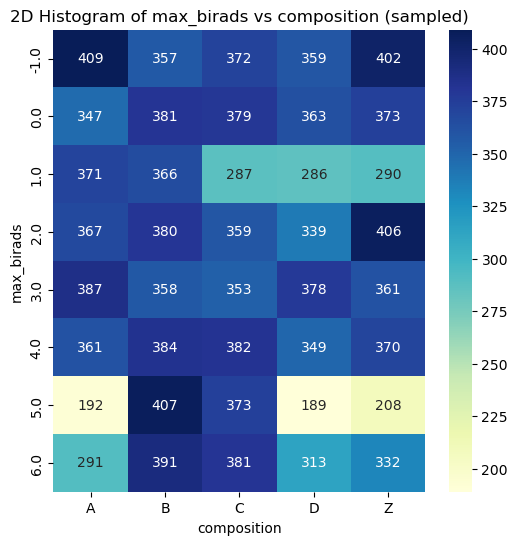

/var/folders/_d/0vwb7s9d6b51rjy794vvr7y80000gn/T/ipykernel_19739/77215205.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby([x_col, y_col]).size().reset_index(name='counts')


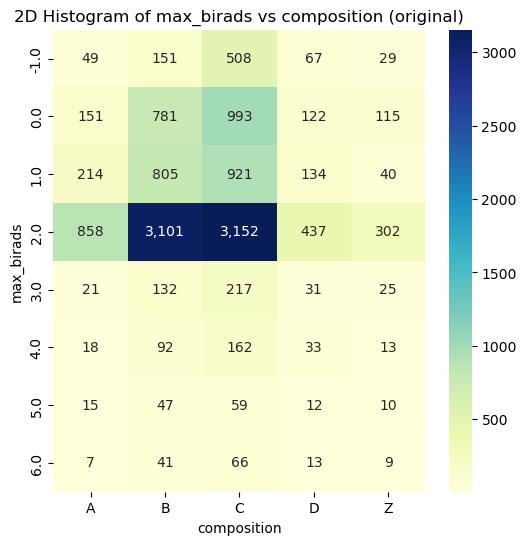

In [214]:
plot_heatmap(df_sample, "max_birads", "composition", "2D Histogram of max_birads vs composition (sampled)");
plot_heatmap(df, "max_birads", "composition", "2D Histogram of max_birads vs composition (original)");

/var/folders/_d/0vwb7s9d6b51rjy794vvr7y80000gn/T/ipykernel_19739/77215205.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby([x_col, y_col]).size().reset_index(name='counts')


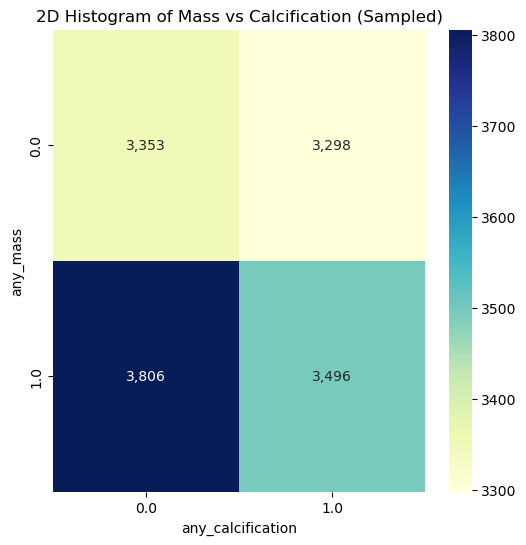

/var/folders/_d/0vwb7s9d6b51rjy794vvr7y80000gn/T/ipykernel_19739/77215205.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby([x_col, y_col]).size().reset_index(name='counts')


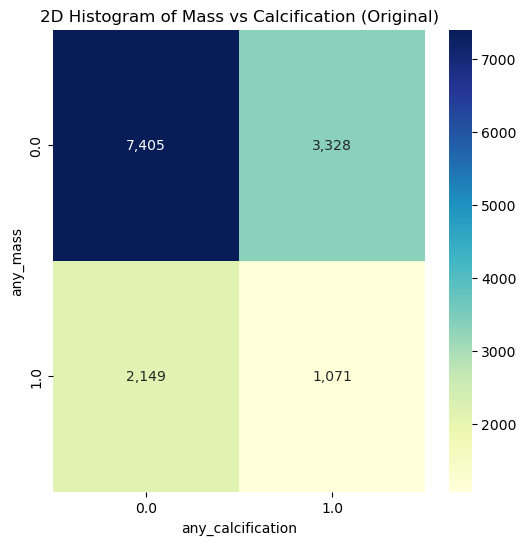

In [215]:
plot_heatmap(df_sample, "any_mass", "any_calcification", "2D Histogram of Mass vs Calcification (Sampled)");
plot_heatmap(df, "any_mass", "any_calcification", "2D Histogram of Mass vs Calcification (Original)");

In [216]:
ref_df = pd.read_csv("./data/ref_table.csv")

In [217]:
df = df.sort_values(by="id").reset_index(drop=True)
ref_df = ref_df.sort_values(by="id").reset_index(drop=True)

In [218]:
len(df), len(ref_df)

(13953, 19874)

In [219]:
# merge the two dataframes using "id" as the key and the column "weight" from df to combined_df
combined_df = ref_df.merge(
    df[
        [
            "id",
            "weight",
            "composition",
            "left_mass",
            "right_mass",
            "left_microcal",
            "right_microcal",
            "left_birads",
            "right_birads",
        ]
    ],
    on="id",
    how="left",
)

In [220]:
combined_df[combined_df.notna().all(axis=1)].head()

,id,report,aug_report,aug_report02,r_cc,r_mlo,l_cc,l_mlo,weight,composition,left_mass,right_mass,left_microcal,right_microcal,left_birads,right_birads
3939,9926605,Scattered areas of glandular density are noted...,Scattered regions of fibroglandular density ar...,Scattered glandular densities are observed in ...,./data/jpegs/9926605_r_cc.jpeg,./data/jpegs/9926605_r_mlo.jpeg,./data/jpegs/9926605_l_cc.jpeg,./data/jpegs/9926605_l_mlo.jpeg,0.046307,B,0,1,0,0,-1,2
4014,9938972,Scattered areas of glandular density are noted...,Scattered regions of glandular density are obs...,Scattered areas of glandular density are seen ...,./data/jpegs/9938972_r_cc.jpeg,./data/jpegs/9938972_r_mlo.jpeg,./data/jpegs/9938972_l_cc.jpeg,./data/jpegs/9938972_l_mlo.jpeg,0.021703,B,0,0,1,1,-1,2
4015,9939023,Scattered areas of glandular density are noted...,Scattered regions of glandular density are obs...,Scattered areas of glandular tissue are seen i...,./data/jpegs/9939023_r_cc.jpeg,./data/jpegs/9939023_r_mlo.jpeg,./data/jpegs/9939023_l_cc.jpeg,./data/jpegs/9939023_l_mlo.jpeg,0.010317,B,0,0,0,0,2,2
4016,9939090,Heterogeneously dense breasts are noted (breas...,Heterogeneously dense breast tissue is observe...,Heterogeneously dense breast tissue is noted (...,./data/jpegs/9939090_r_cc.jpeg,./data/jpegs/9939090_r_mlo.jpeg,./data/jpegs/9939090_l_cc.jpeg,./data/jpegs/9939090_l_mlo.jpeg,0.085369,C,1,1,1,1,2,2
4017,9939146,The breast parenchyma is almost fatty (breast ...,The breast tissue primarily consists of nearly...,The breast parenchyma is predominantly compose...,./data/jpegs/9939146_r_cc.jpeg,./data/jpegs/9939146_r_mlo.jpeg,./data/jpegs/9939146_l_cc.jpeg,./data/jpegs/9939146_l_mlo.jpeg,0.545647,A,1,1,1,1,0,2


In [222]:
combined_df[combined_df.notna().all(axis=1)].sort_values(by='id').to_csv("./data/essential-mammo.csv", index=False)